In [1]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pynverse
import matplotlib.pyplot as pp
import proplot as ppt
import tueplots.bundles
import tueplots.axes
from tueplots.constants import markers
from cycler import cycler

from common import *
from vdp import vdp_cycle_length, vdp_cycle_length_numeric, good_starting_point, vdp, solve_vdp, evenly_distributed_starting_points

In [2]:
neurips_bundle = tueplots.bundles.neurips2022()
del neurips_bundle["figure.constrained_layout.use"]
pp.rcParams.update(neurips_bundle)
pp.rcParams.update(tueplots.axes.tick_direction())
pp.rcParams["text.latex.preamble"] += r"\usepackage{nicefrac}"
pp.rcParams["pgf.preamble"] = pp.rcParams["text.latex.preamble"]

In [3]:
%matplotlib inline

# Generate VdP Data

In [4]:
mu = 25.0
atol = 1e-8
rtol = 1e-5
y0 = good_starting_point(mu, atol=atol, rtol=rtol)
cycle_length = vdp_cycle_length_numeric(mu)
sol = solve_vdp(mu, t0=0.0, t1=cycle_length, y0=y0, t_eval=None, atol=atol, rtol=rtol, method="RK45")

# Place the evaluation points about equidistant in phase space
phase_space_velocity = np.linalg.norm(np.diff(sol.y, axis=1) / np.diff(sol.t), axis=0)
phase_space_length = np.linalg.norm(np.diff(sol.y, axis=1), axis=0).cumsum()
interp_f = interp1d(sol.t[1:], phase_space_length, fill_value="extrapolate")
t_eval_plot = np.clip(pynverse.inversefunc(interp_f, np.linspace(0.0, phase_space_length.max(), num=1000)), 0.0, cycle_length)
sol_plot = solve_vdp(mu, t0=0.0, t1=cycle_length, y0=y0, t_eval=t_eval_plot, atol=atol, rtol=rtol, method="RK45")

In [5]:
n_overlays = 2
y0n = evenly_distributed_starting_points(n_overlays, mu, cycle_length, atol=atol, rtol=rtol, n_steps=50_000)
soln = solve_vdp(mu, t0=0.0, t1=cycle_length, y0=y0n.ravel(), t_eval=None, atol=atol, rtol=rtol, method="RK45")
overlay_sols = [solve_vdp(mu, t0=0.0, t1=cycle_length, y0=y0n[:, i], t_eval=None, atol=atol, rtol=rtol, method="RK45") for i in range(n_overlays)]

In [6]:
def smooth(sol, cutoff):
    fft = np.fft.rfft(np.diff(sol.t))
    fft[cutoff:] = 0
    return np.fft.irfft(fft)

dt = smooth(sol, 35)
dtn = smooth(soln, 35)
dt_overlays = [smooth(s, 35) for s in overlay_sols]

In [7]:
df = pd.read_pickle("vdp-steps.pickle")

step_data = {}
for _, row in df.iterrows():
    if row.method not in step_data:
        step_data[row.method] = ([], [])
    step_data[row.method][0].append(row["batch-size"])
    step_data[row.method][1].append(row["steps"])

# Explanatory Figure

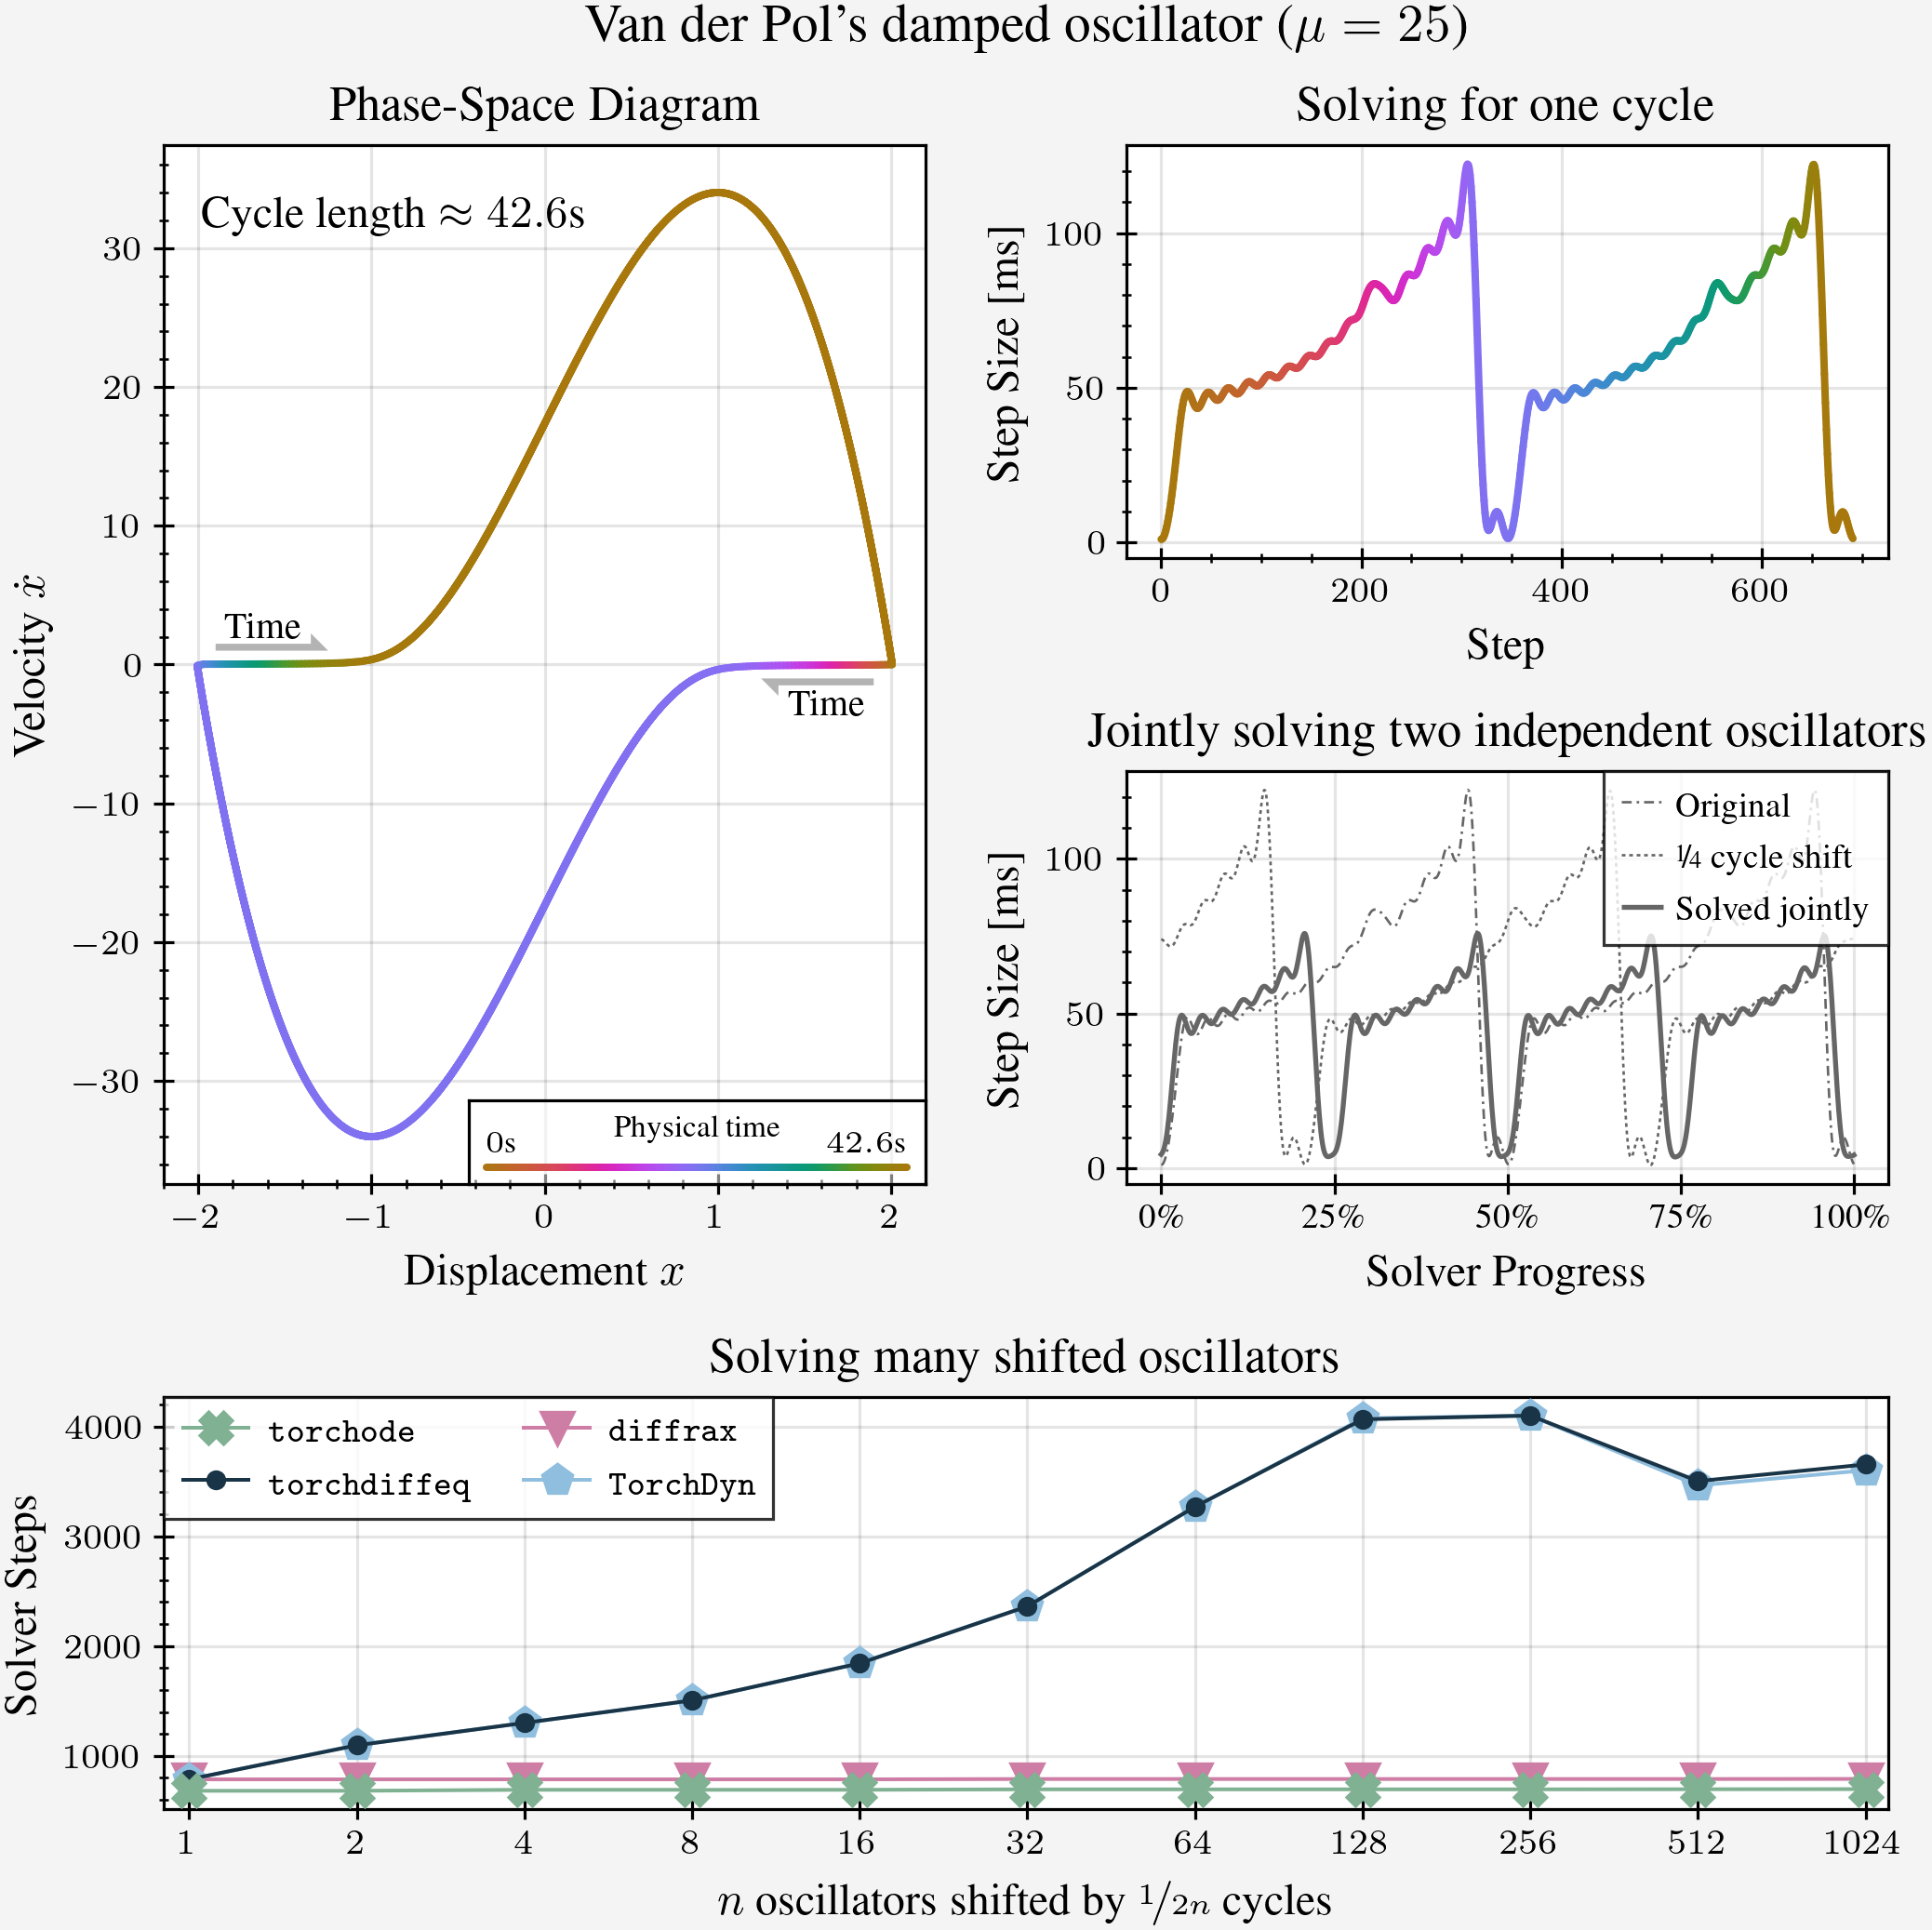

In [8]:
cmap = "Phase"

fig = ppt.figure(figtitle=rf"Van der Pol's damped oscillator ($\mu = {mu:.0f}$)", dpi=192, share=False, suptitle_kw={"size": "large"}, suptitlepad=7.0, figsize=(5.5, 5.5))
gs = ppt.GridSpec(nrows=3, ncols=2, wspace=4.5, width_ratios=[0.5, 0.5])
ax_vdp = fig.add_subplot(gs[:2, 0])
ax_size = fig.add_subplot(gs[0, 1])
ax_overlaid = fig.add_subplot(gs[1, 1], sharey=ax_size)
ax_steps = fig.add_subplot(gs[2, :])

t_norm = pp.Normalize(0.0, cycle_length)
ax_vdp.format(
    title="Phase-Space Diagram",
    xlabel="Displacement $x$", ylabel="Velocity $\dot{x}$", xlim=(-2.2, 2.2))
ax_vdp.parametric(*sol_plot.y, c=sol_plot.t, cmap=cmap, norm=t_norm, interp=5, joinstyle="round", capstyle="round")
ax_vdp.text(0.05, 0.95, rf"Cycle length $\approx {cycle_length:.1f}$s", va="top", ha="left", transform="axes")
ax_vdp.text(-1.85, 1.3, "Time", va="bottom", ha="left", transform="data", fontsize="small")
ax_vdp.arrow(-1.9, 1.0, 0.65, 0.0,
             width=1.0, head_width=2.5, head_length=0.1, length_includes_head=True, shape="right",
             edgecolor="none", facecolor="0.7")
ax_vdp.text(1.85, -1.85, "Time", va="top", ha="right", transform="data", fontsize="small")
ax_vdp.arrow(1.9, -1.0, -0.65, 0.0,
             width=1.0, head_width=2.5, head_length=0.1, length_includes_head=True, shape="right",
             edgecolor="none", facecolor="0.7")
ix = ax_vdp.inset((0.4, 0.0, 0.6, 0.08), zoom=False)
ix.format(grid=False, xticks=False, yticks=False)
ix.patch.set_alpha(0.5)
ix.text(0.5, 0.5, "Physical time", va="bottom", ha="center", size="x-small", transform="axes")
ix.text(0.04, 0.3, r"$0$s", va="bottom", ha="left", size="x-small", transform="axes")
ix.text(0.96, 0.3, r"$42.6$s", va="bottom", ha="right", size="x-small", transform="axes")
ix.parametric(np.linspace(0.04, 0.96, 100), np.full(100, 0.2), c=np.linspace(0.0, 1.0, 100),
              cmap=cmap, transform=ix.transAxes, joinstyle="round", capstyle="round")

margin = 0.05
ax_size.format(title="Solving for one cycle", xlabel="Step", ylabel="Step Size [ms]", xlim=(-margin*len(dt), (1 + margin) * len(dt)))
ax_size.parametric(np.arange(len(dt)), dt * 1000, c=sol.t[1:], cmap=cmap, norm=t_norm, joinstyle="round", capstyle="round")

ylim_size = ax_size.get_ylim()
ax_overlaid.format(title="Jointly solving two independent oscillators", xlabel="Solver Progress", ylabel="Step Size [ms]",
                   xlim=(-margin, (1 + margin)), ylim=(ylim_size[0], ylim_size[1]), xticks=np.linspace(0.0, 1.0, 5), xticklabels=[f"{i}\\%" for i in range(0, 101, 25)])
line_styles = [(0.0, (4.0, 2.0, 1.0, 2.0)), (0.0, (1.5, 1.5))]
lines = []
for i, dt_overlay in enumerate(dt_overlays):
    line = ax_overlaid.plot(np.linspace(0, 1, len(dt_overlay)), dt_overlay * 1000, lw=0.5, c="0.4", ls=line_styles[i])
    lines.append(line[0])
line_joint = ax_overlaid.plot(np.linspace(0, 1, len(dtn)), dtn * 1000, lw=1.0, ls="-", c="0.4")
ax_overlaid.legend(lines + [line_joint], ["Original", r"\nicefrac{1}{4} cycle shift", "Solved jointly"],
                   frameon=True, ncols=1, loc="upper right", handlelength=1.2, handletextpad=0.4, columnspacing=0.5)

steps_batch_sizes = next(iter(step_data.items()))[1][0]
ax_steps.format(title="Solving many shifted oscillators", xlabel=r"$n$ oscillators shifted by $\nicefrac{1}{2n}$ cycles", ylabel="Solver Steps",
                xscale="log", xticks=steps_batch_sizes, xminorticks=[], xlim=[0.9, 1024 * 1.1])
ax_steps.set_prop_cycle(cycler(marker=["X", "v", ".", "p"], color=["#80B192","#ce7da5","#183446","#90bede"]))
step_methods = [("torchode", "torchode"), ("diffrax", "diffrax"), ("torchdiffeq", "torchdiffeq"), ("torchdyn", "TorchDyn")]
zorder = {"torchode": 5, "torchdiffeq": 4, "torchdyn": 3, "diffrax": 2}
offsets = {"torchode": 0, "torchdiffeq": 0, "torchdyn": 0, "diffrax": 0}
for method, label in step_methods:
    batch_sizes, steps = step_data[method]
    ax_steps.plot(np.array(batch_sizes) + offsets[method], steps, label=rf"\texttt{{{label}}}", zorder=zorder[method], lw=0.75)
ax_steps.legend(loc="upper left", ncol=2, frameon=True)

In [9]:
fig.savefig(figroot / "van-der-pol.pdf", bbox_inches="tight", pad_inches=0.0)

# Benchmark

In [10]:
df = pd.read_pickle("vdp-benchmark.pickle").set_index(["method"])

for method, row in df.iterrows():
    loop_times = row.times / row.steps
    print(row.name, loop_times.mean(), loop_times.std())

torchode-jit 1.6292623181818182 0.010271682685701741
torchode 3.2063229696969695 0.11304201418274697
torchdiffeq 3.5751667285714284 0.03736735876300882
torchdyn 3.535048204761905 0.0722893717746423
diffrax-jit 0.9014336458333334 0.0011068024496219393
